### Predictive model for PREPAID – MI Cross Sell (IDD Callers / Migrants) 

### Objective: 
- To increase number of Mobile Internet subscribers among IDD Callers / Migrants for the coming MI campaign 

### Impact on Business:
- Increase data spending by Prepaid IDD Callers / Migrants 


### Study period:
- Sep-Dec 2017


### Selection Criterion:

- Prepaid IDD Callers / Migrants 
    - Active Prepaid subs who were activated before Sep ‘17, i.e. LOS >=3 during the study period
    - Made IDD call in Sep, Oct and Nov ‘2017 consecutively


### Target Definition: 

- Target = 0
    - Pure Non MI Taker (Sep'17 - Dec'17)
    
    
- Target = 1
    - New MI Takers (Sep'17 - Nov'17 w/o MI but take up MI in Dec'17)


- Sample size : 178,156 

## Data Exploration

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
import numpy as np
import pandas as pd
from IPython.display import display 

#Data Load
df = pd.read_csv('../data/project/OFW_MI_CSELL_MODEL_BASE.csv')
df.head()

,SUBSCRIBER_ARRANGEMENT_ID,DATA_DAY,NAME_PREPAID_BRAND2,DEVICE_OS_TYPE2,NETWORK_BANDS,DEVICE_TYPE,GENDER,AGE2,TOP_IDD_COUNTRY,RACE,...,SWX_DATA,SWX_IDD,MI_T1,MI_T2,MI_T3,MI_T4,MI_T5,MI_5MONTH,MI_4MONTH,MI_TAG
0,65448788,00:00.0,X2,ANDROID,3G,SMART PHONE,MALE,24,UNKNOWN,MALAY,...,6.666667,2.333333,0,0,0,1,0,1,1,1
1,66158847,00:00.0,LEGACYXPAX,UNKNOWN,NO DATA,BASIC PHONE,FEMALE,41,UNKNOWN,MALAY,...,0.000000,7.000000,0,0,0,1,0,1,1,1
2,66281977,00:00.0,LEGACYXPAX,ANDROID,3G,SMART PHONE,FEMALE,67,UNKNOWN,MALAY,...,0.000000,4.000000,0,0,0,1,0,1,1,1
3,66523177,00:00.0,X2,ANDROID,3G,SMART PHONE,FEMALE,42,UNKNOWN,MALAY,...,0.000000,3.333333,0,0,0,0,1,1,0,0
4,68730634,00:00.0,X2,ANDROID,3G,SMART PHONE,MALE,36,UNKNOWN,MALAY,...,0.000000,7.666667,0,0,0,0,1,1,0,0


In [6]:
### Drop Non-related Columns
df=df.iloc[:,16:]

### Count Check
df["MI_TAG"].value_counts()

0    168765
1      9391
Name: MI_TAG, dtype: int64

### Impute / Replace Missing values
- To check on missing values by showing columns that have missing values

In [7]:
df.columns[df.isnull().sum() > 0]

### There is no missing value

Index([], dtype='object')

## Data Preprocessing

### Train Test Split 
- Splitting the data into 70% training and 30% test subsets

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(['MI_T1','MI_T1','MI_T2','MI_T3','MI_T4','MI_T5','MI_5MONTH','MI_4MONTH','MI_TAG'], axis=1)
y = df['MI_TAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)


print(X_train.shape)
print(X_test.shape)

(124709, 74)
(53447, 74)


### Resolving Low Variance
- remove columns with 80% similar data (e.g. 80% of the columns are 0)

In [9]:
from sklearn.feature_selection import VarianceThreshold

selector_variance = VarianceThreshold(.8*(1-.8))
selector_variance.fit(X_train)

attribs_variant = list(X_train.columns[selector_variance.get_support()])

X_train = X_train[attribs_variant]

X_train.shape

(124709, 73)

### Resolving Multicollinearity 

In [10]:
### 1.find correlation between features
X_train_corr = X_train.corr(method='spearman')

### 2. find variance inflation factor of features
from statsmodels.stats.outliers_influence import variance_inflation_factor
def cal_vif(data):
    vifs = pd.Series()
    for i, attrib in enumerate(data.columns):
        vif = variance_inflation_factor(data.values, i)
        vifs[attrib] = vif
    return vifs

X_train_vif = cal_vif(X_train)

C:\Users\09607\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [11]:
def get_high_correlated_features(threshold_corr, threshold_vif, data, data_corr, data_vif):
    col_corr = set()
    for i in range(data_corr.shape[0]):
        for j in range(i):
            if data_corr.iloc[i,j] >= threshold_corr:
                feature_i = data.columns[i]
                feature_j = data.columns[j]
                print("{}.{} against {}.{}".format(i,feature_i,j,feature_j))
                vif_i = data_vif.iloc[i]
                vif_j = data_vif.iloc[j]
                if np.isinf(vif_i) and np.isinf(vif_j):
                    col_corr.add(feature_i)
                    col_corr.add(feature_j)
                    print('both vif are infinity')
                elif vif_i>vif_j and vif_i>threshold_vif:
                    col_corr.add(feature_i)
                elif vif_j>vif_i and vif_j>threshold_vif:
                    col_corr.add(feature_j)
                else:
                    print('both vif less than 10')
    return col_corr

In [12]:
attribs_num_correlated = get_high_correlated_features(0.5, 10, X_train, X_train_corr, X_train_vif)

3.MAX_CONSECUTIVE_ZERO_DAY against 0.DAYS_TO_NE
both vif less than 10
6.AMT_RELOAD against 4.ACTIVE_DAY_MTH
7.NUM_RELOAD against 4.ACTIVE_DAY_MTH
7.NUM_RELOAD against 6.AMT_RELOAD
9.KB_PPU against 8.AMT_PPU
11.AMT_OUT_CALL_ONNET against 10.AMT_OUT_CALL
12.AMT_OUT_CALL_OFFNET against 10.AMT_OUT_CALL
13.AMT_OUT_CALL_DOMESTIC against 10.AMT_OUT_CALL
13.AMT_OUT_CALL_DOMESTIC against 11.AMT_OUT_CALL_ONNET
13.AMT_OUT_CALL_DOMESTIC against 12.AMT_OUT_CALL_OFFNET
15.AMT_OUT_CALL_IDD against 10.AMT_OUT_CALL
15.AMT_OUT_CALL_IDD against 12.AMT_OUT_CALL_OFFNET
17.AMT_OUT_SMS_ONNET against 16.AMT_OUT_SMS
18.AMT_OUT_SMS_OFFNET against 16.AMT_OUT_SMS
18.AMT_OUT_SMS_OFFNET against 17.AMT_OUT_SMS_ONNET
19.AMT_OUT_SMS_INTL against 16.AMT_OUT_SMS
19.AMT_OUT_SMS_INTL against 18.AMT_OUT_SMS_OFFNET
30.MOU_OUT_CALL_ONNET against 11.AMT_OUT_CALL_ONNET
30.MOU_OUT_CALL_ONNET against 17.AMT_OUT_SMS_ONNET
31.MOU_OUT_CALL_OFFNET against 4.ACTIVE_DAY_MTH
31.MOU_OUT_CALL_OFFNET against 6.AMT_RELOAD
31.MOU_OUT_CALL_O

In [13]:
attribs_num_selected = list(X_train.drop(attribs_num_correlated, axis=1).columns)
attribs_num_selected

['DAYS_TO_NE',
 'CREDIT_BALANCE',
 'CREDIT_BEF_RELOAD',
 'MAX_CONSECUTIVE_ZERO_DAY',
 'AMT_LAST_RELOAD',
 'KB_PPU',
 'AMT_OUT_CALL_DOMESTIC',
 'AMT_OUT_CALL_FIXED',
 'AMT_OUT_CALL_IDD',
 'AMT_OUT_CALL_IDD_COUNTRY1',
 'AMT_OUT_CALL_IDD_COUNTRY2',
 'AMT_OUT_CALL_IDD_COUNTRY3',
 'AMT_OUT_CALL_IDD_COUNTRY4',
 'AMT_OUT_CALL_IDD_COUNTRY5',
 'AMT_OUT_CALL_IDD_COUNTRY6',
 'AMT_OUT_CALL_IDD_COUNTRY7',
 'AMT_OUT_CALL_IDD_COUNTRY8',
 'AMT_OUT_CALL_IDD_COUNTRY9',
 'AMT_OUT_CALL_IDD_COUNTRY10',
 'MOU_OUT_CALL_FIXED',
 'MOU_OUT_CALL_FREE',
 'MOU_OUT_CALL_IDD_COUNTRY6',
 'NUM_OUT_CALL_FIXED',
 'NUM_OUT_CALL_FREE',
 'AMT_ATS_RCV',
 'AMT_ATS_SEND',
 'NUM_ATS_RCV',
 'NUM_ATS_SEND',
 'NUM_OUT_CALL_DROP',
 'NON_RECURRING_REVENUE',
 'DATA_VOLUME',
 'SWX_SMS',
 'SWX_DATA']

### Scaling for Outlier Treatment

In [14]:
from sklearn.preprocessing import StandardScaler,Normalizer,QuantileTransformer,MinMaxScaler

X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train[attribs_num_selected]),
                                  columns=attribs_num_selected)

In [15]:
from sklearn.ensemble import IsolationForest

def resolve_outlier(data):
    n_samples = 200
    outliers_fraction = 0.01
    outlier_detection = pd.DataFrame()
    outlier_clf = IsolationForest(max_samples=n_samples,contamination=outliers_fraction,random_state=42)
    outlier_clf.fit(data)
    outlier_detection['IsolationForest'] = outlier_clf.predict(data)
    return outlier_detection

In [18]:
outlier_detection = resolve_outlier(X_train_scaled)

X_train_xoutlier = X_train.iloc[outlier_detection[outlier_detection['IsolationForest'] == 1].index][attribs_num_selected]
y_train_xoutlier = y_train.iloc[outlier_detection[outlier_detection['IsolationForest'] == 1].index]

X_train_xoutlier.shape

(123461, 33)

### Downsampling
- The data is imbalanced, perform downsampling to balance the data. 

In [19]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(return_indices=True, random_state=123)
X_train, y_train, idx_resampled = rus.fit_sample(X_train_xoutlier, y_train_xoutlier)
print('Y train:', np.unique(y_train,return_counts=True))

Y train: (array([0, 1], dtype=int64), array([6571, 6571], dtype=int64))


### Scale Data

In [20]:
scaler = StandardScaler()

X_train= pd.DataFrame(scaler.fit_transform(X_train), columns = X_train_xoutlier.columns)

X_test = pd.DataFrame(scaler.transform(X_test[attribs_num_selected]), columns = attribs_num_selected)
X_test.head()

,DAYS_TO_NE,CREDIT_BALANCE,CREDIT_BEF_RELOAD,MAX_CONSECUTIVE_ZERO_DAY,AMT_LAST_RELOAD,KB_PPU,AMT_OUT_CALL_DOMESTIC,AMT_OUT_CALL_FIXED,AMT_OUT_CALL_IDD,AMT_OUT_CALL_IDD_COUNTRY1,...,NUM_OUT_CALL_FREE,AMT_ATS_RCV,AMT_ATS_SEND,NUM_ATS_RCV,NUM_ATS_SEND,NUM_OUT_CALL_DROP,NON_RECURRING_REVENUE,DATA_VOLUME,SWX_SMS,SWX_DATA
0,0.058216,-0.344942,-0.171300,-0.901898,-0.192603,-0.02693,-0.456367,-0.171210,-0.710245,-0.382711,...,-0.032652,-0.155221,-0.150355,-0.160184,-0.158563,0.060110,0.201395,0.158193,-0.283389,0.242374
1,0.116160,-0.202774,-0.180419,-0.191116,-0.406931,-0.02693,0.285301,-0.139735,-0.372102,0.056792,...,0.722833,-0.155221,-0.150355,-0.160184,-0.158563,-0.594555,-0.414787,-0.554019,-0.149980,-0.612156
2,0.046627,-0.190535,-0.180419,-0.901898,-0.621258,-0.02693,-0.266570,-0.171210,2.191088,-0.467710,...,-0.032652,-0.155221,-0.150355,-0.160184,-0.158563,0.205591,-0.089580,-0.532739,-0.616910,0.876379
3,0.182795,-0.116979,-0.180419,1.052754,-0.621258,-0.02693,-0.101755,-0.171210,-0.492888,-0.467710,...,-0.032652,-0.155221,-0.150355,-0.160184,-0.158563,-0.521814,-0.414787,-0.553456,-0.683614,-0.860245
4,0.101674,0.255624,-0.180419,-0.813050,-0.406931,-0.02693,-0.480700,-0.171210,0.689453,-0.467710,...,-0.032652,-0.155221,-0.150355,-0.160184,-0.158563,-0.449074,-0.414787,0.162865,-0.683614,1.400123


## Model Training And Evaluation 

Data used for training and Validation
- downsampling data 

Data splitting (default parameter):
- 70% training
- 30% testing

Classifier:
- Gaussian Naive Bayes
- Logistic Regression
- Random Forest

Perform model evaluation using the following metrics:

- Accuracy score
- Confusion Matrix
- Precision and Recall Scores
- F1 score
- ROC and AUC

### Gaussian Naive Bayes

Accuracy of NB classifier on training set: 0.592071222036
Accuracy of NB classifier on test set: 0.642094037083
MSE: 0.598252424079

             precision    recall  f1-score   support

          0       0.96      0.65      0.77     50688
          1       0.08      0.53      0.13      2759

avg / total       0.92      0.64      0.74     53447



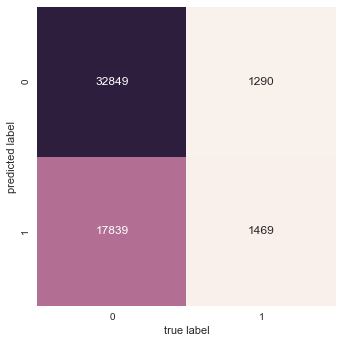

ROC Curve
AUROC Score: 0.598612951678


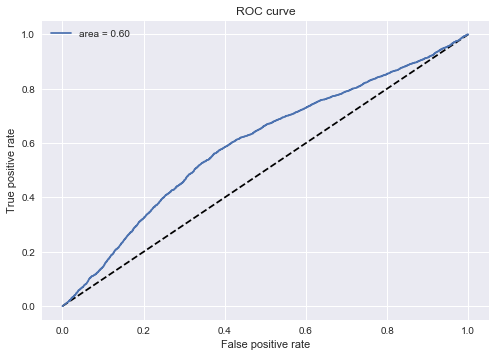

In [26]:
## Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
nbclf = GaussianNB().fit(X_train, y_train)

y_predict_nb = nbclf.predict(X_test)

print('Accuracy of NB classifier on training set:', nbclf.score(X_train, y_train))
print('Accuracy of NB classifier on test set:', nbclf.score(X_test, y_test))
print('MSE:', mean_squared_error(y_test, y_predict_nb)**0.5)
print('')

print(classification_report(y_test, y_predict_nb))

mat = confusion_matrix(y_test, y_predict_nb)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();

from sklearn.metrics import roc_auc_score

predict_proba_y_nb = nbclf.predict_proba(X_test)[:,1]


from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predict_proba_y_nb, pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_test, predict_proba_y_nb))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [27]:
PPV_NB = 1469/(1469+17839)

Prevelance_NB= (1469+1290)/53447

Lift_NB= PPV_NB/Prevelance_NB

print('PPV:',PPV_NB)
print('Prevelance:',Prevelance_NB)
print('Lift:',Lift_NB)


PPV: 0.07608245286927698
Prevelance: 0.051621232248769806
Lift: 1.4738596805017206


### Grid Search Logistic Regression with Dowsampling - No Feature Selection

GridSearch Logistic Regression Best Penalty: l2
GridSearch Logistic Regression Best C: 0.01
Accuracy of Log. Reg. classifier on training set: 0.620453507837
Accuracy of Log. Reg. classifier on test set: 0.658315714633


Classification report :

              precision    recall  f1-score   support

          0       0.97      0.66      0.79     50688
          1       0.08      0.57      0.15      2759

avg / total       0.92      0.66      0.75     53447

Confusion Matrix:


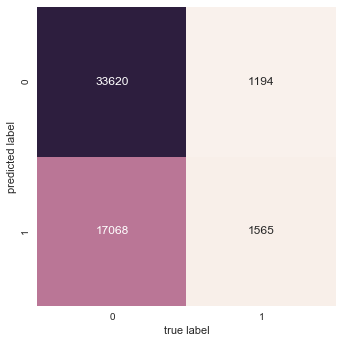

ROC Curve
AUROC Score: 0.648729008953


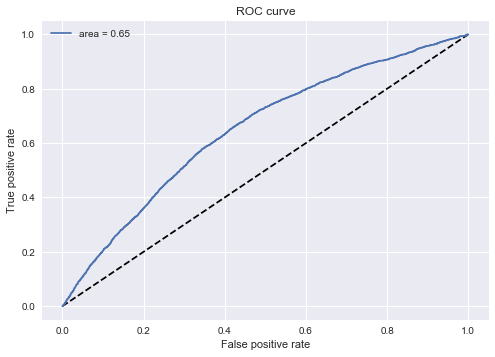

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
log = LogisticRegression(random_state=0)

#Regularization penalty space
penalty = ['l1', 'l2']

#Regularization hyperparameter space
C = [0.01, 0.1, 1, 10, 100]

#Hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

#Grid search using 3-fold cross validation
kfold = StratifiedKFold(n_splits=3) 
logclf = GridSearchCV(log, hyperparameters, cv=kfold, verbose=0)

#Fit Grid Search 
best_model = logclf.fit(X_train, y_train)

print('GridSearch Logistic Regression Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('GridSearch Logistic Regression Best C:', best_model.best_estimator_.get_params()['C'])

print('Accuracy of Log. Reg. classifier on training set:', best_model.score(X_train, y_train))
print('Accuracy of Log. Reg. classifier on test set:', best_model.score(X_test, y_test))

from sklearn import metrics
ypred_logistic = best_model.predict(X_test)
print('\n\nClassification report :\n\n', classification_report(y_test, ypred_logistic))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print('Confusion Matrix:')
mat_logistic = confusion_matrix(y_test, ypred_logistic)
sns.heatmap(mat_logistic.T, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();

from sklearn.metrics import roc_auc_score

predict_proba_y = best_model.predict_proba(X_test)
predict_proba_y = best_model.predict_proba(X_test)[:,1]


from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predict_proba_y, pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_test, predict_proba_y))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [31]:
PPV_Log = 1565/(1565+17068)

Prevelance_Log = (1565+1194)/53447

Lift_Log = PPV_Log/Prevelance_Log

print('PPV:',PPV_Log)
print('Prevelance:',Prevelance_Log)
print('Lift:',Lift_Log)


PPV: 0.08399076906563624
Prevelance: 0.051621232248769806
Lift: 1.6270585843606598


### Grid Search Logistic Regression with Dowsampling - Feature Selection

In [32]:
### Feature Selection: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
log = LogisticRegression(random_state=0,class_weight='balanced', C=0.01)
select_from_model = SelectFromModel(log, threshold='median')
select_from_model.fit(X_train, y_train)
attribs_selected = list(X_train.columns[select_from_model.get_support()])

X_train_feature_Log=X_train[attribs_selected]

X_test_feature_Log =X_test[attribs_selected]

X_train_feature_Log.shape

(13142, 17)

GridSearch Logistic Regression Best Penalty: l2
GridSearch Logistic Regression Best C: 10
Accuracy of Log. Reg. classifier on training set: 0.620910059352
Accuracy of Log. Reg. classifier on test set: 0.656650513593


Classification report :

              precision    recall  f1-score   support

          0       0.97      0.66      0.79     50688
          1       0.08      0.57      0.15      2759

avg / total       0.92      0.66      0.75     53447

Confusion Matrix:


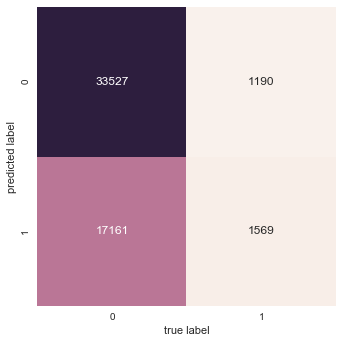

ROC Curve
AUROC Score: 0.646899496563


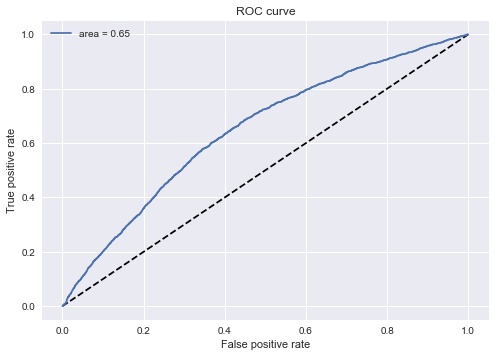

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
log = LogisticRegression(random_state=0)

#Regularization penalty space
penalty = ['l1', 'l2']

#Regularization hyperparameter space
C = [0.01, 0.1, 1, 10, 100]

#Hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


#Grid search using 3-fold cross validation
kfold = StratifiedKFold(n_splits=3) 
logclf1 = GridSearchCV(log, hyperparameters, cv=kfold, verbose=0)

#Fit Grid Search 
best_model = logclf1.fit(X_train_feature_Log, y_train)

print('GridSearch Logistic Regression Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('GridSearch Logistic Regression Best C:', best_model.best_estimator_.get_params()['C'])

print('Accuracy of Log. Reg. classifier on training set:', best_model.score(X_train_feature_Log, y_train))
print('Accuracy of Log. Reg. classifier on test set:', best_model.score(X_test_feature_Log, y_test))

from sklearn import metrics
ypred_logistic = best_model.predict(X_test_feature_Log)
print('\n\nClassification report :\n\n', classification_report(y_test, ypred_logistic))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print('Confusion Matrix:')
mat_logistic = confusion_matrix(y_test, ypred_logistic)
sns.heatmap(mat_logistic.T, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();

from sklearn.metrics import roc_auc_score

predict_proba_y = best_model.predict_proba(X_test_feature_Log)[:,1]

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predict_proba_y, pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_test, predict_proba_y))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [34]:
PPV_Log_feature = 1569/(1569+17161)

Prevelance_Log_feature = (1569+1190)/53447

Lift_Log_feature = PPV_Log_feature/Prevelance_Log_feature

print('PPV:',PPV_Log_feature)
print('Prevelance:',Prevelance_Log_feature)
print('Lift:',Lift_Log_feature)


PPV: 0.08376935397757608
Prevelance: 0.051621232248769806
Lift: 1.6227693592024317


### Grid Search Random Forest with Dowsampling - No Feature Selection

In [35]:
# Grid Search for Random Forest
from sklearn.model_selection import StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

kfold = StratifiedKFold(n_splits=3) 

rfclf = RandomForestClassifier(random_state=0)
parameter =[{'n_estimators' : [1,5,10,20,40,80,100,200,500,1000],
             'max_depth' : [4,5,6,7]}]

tree_grid = GridSearchCV(rfclf,parameter, cv=kfold)
tree_grid.fit(X_train,y_train)

print(tree_grid)
print('')
print(tree_grid.best_score_) 
print(tree_grid.best_estimator_.n_estimators) 
print(tree_grid.best_estimator_.max_depth) 


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [1, 5, 10, 20, 40, 80, 100, 200, 500, 1000], 'max_depth': [4, 5, 6, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

0.656140617866
100
7


Accuracy of RF classifier on training set: 0.68
Accuracy of RF classifier on test set: 0.57

Confusion matrix :



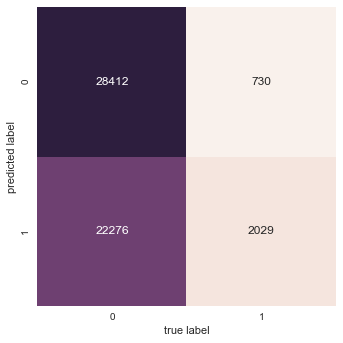



Classification report :

              precision    recall  f1-score   support

          0       0.97      0.56      0.71     50688
          1       0.08      0.74      0.15      2759

avg / total       0.93      0.57      0.68     53447

ROC Curve


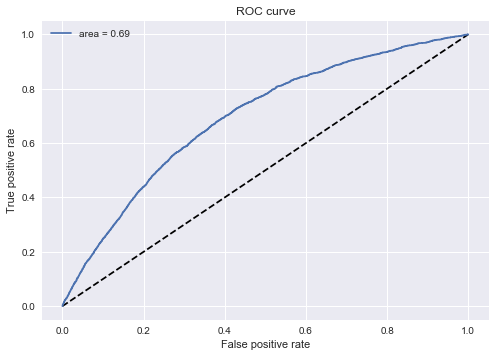

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Random Forest

# without reduction
rfclf = RandomForestClassifier(n_estimators=100, max_depth=7)
rfclf.fit(X_train, y_train)

predict_y_RF = rfclf.predict(X_test)
predict_proba_y_RF = rfclf.predict_proba(X_test)[:,1]

print('Accuracy of RF classifier on training set: {:.2f}'
     .format(rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(rfclf.score(X_test, y_test)))

print('\nConfusion matrix :\n')
mat = confusion_matrix(y_test, predict_y_RF)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();


print('\n\nClassification report :\n\n', classification_report(y_test, predict_y_RF))

fpr, tpr, thresholds = roc_curve(y_test, predict_proba_y_RF, pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [36]:
PPV_RF = 2030/(2030+22279)

Prevelance_RF = (2030+729)/53447

Lift_RF = PPV_RF/Prevelance_RF

print('PPV:',PPV_RF)
print('Prevelance:',Prevelance_RF)
print('Lift:',Lift_RF)


PPV: 0.08350816569994653
Prevelance: 0.051621232248769806
Lift: 1.6177096528325634


### Grid Search Random Forest with Dowsampling - Feature Selection

In [37]:
### Feature Selection: Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
rf = RandomForestClassifier(random_state=0,class_weight='balanced', max_depth=5)
select_from_model = SelectFromModel(rf, threshold='median')
select_from_model.fit(X_train, y_train)
attribs_selected_RF = list(X_train.columns[select_from_model.get_support()])

X_train_feature_RF=X_train[attribs_selected_RF]

X_test_feature_RF =X_test[attribs_selected_RF]

X_train_feature_RF.shape

(13142, 17)

In [38]:
# Grid Search for Random Forest
from sklearn.model_selection import StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

kfold = StratifiedKFold(n_splits=3) 

rfclf1 = RandomForestClassifier(random_state=0)
parameter =[{'n_estimators' : [1,5,10,20,40,80,100,200,500,1000],
             'max_depth' : [4,5,6,7]}]

tree_grid = GridSearchCV(rfclf1,parameter,cv=kfold)
tree_grid.fit(X_train_feature_RF,y_train)

print(tree_grid)
print('')
print(tree_grid.best_score_) 
print(tree_grid.best_estimator_.n_estimators) 
print(tree_grid.best_estimator_.max_depth) 


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [1, 5, 10, 20, 40, 80, 100, 200, 500, 1000], 'max_depth': [4, 5, 6, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

0.65583625019
500
6


Accuracy of RF classifier on training set: 0.65
Accuracy of RF classifier on test set: 0.56

Confusion matrix :



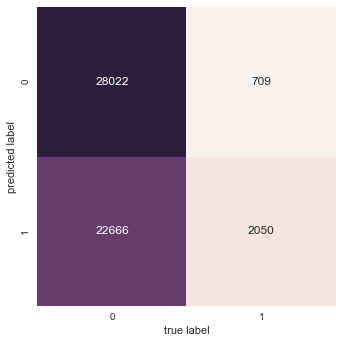



Classification report :

              precision    recall  f1-score   support

          0       0.98      0.55      0.71     50688
          1       0.08      0.74      0.15      2759

avg / total       0.93      0.56      0.68     53447

ROC Curve


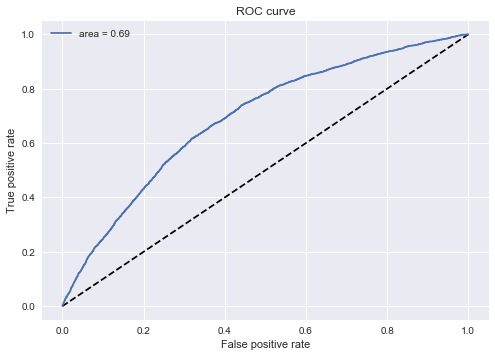

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Random Forest

rfclf1 = RandomForestClassifier(n_estimators=500, max_depth=6)
rfclf1.fit(X_train_feature_RF, y_train)

predict_y_RF1 = rfclf1.predict(X_test_feature_RF)
predict_proba_y_RF1 = rfclf1.predict_proba(X_test_feature_RF)[:,1]

print('Accuracy of RF classifier on training set: {:.2f}'
     .format(rfclf1.score(X_train_feature, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(rfclf1.score(X_test_feature_RF, y_test)))

print('\nConfusion matrix :\n')
mat = confusion_matrix(y_test, predict_y_RF1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show();


print('\n\nClassification report :\n\n', classification_report(y_test, predict_y_RF1))

fpr, tpr, thresholds = roc_curve(y_test, predict_proba_y_RF1, pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [2]:
PPV_RF_feature = 1569/(1569+17161)

Prevelance_RF_feature = (1569+1190)/53447

Lift_RF_feature = PPV_RF_feature/Prevelance_RF_feature

print('PPV:',PPV_RF_feature)
print('Prevelance:',Prevelance_RF_feature)
print('Lift:',Lift_RF_feature)


PPV: 0.08376935397757608
Prevelance: 0.051621232248769806
Lift: 1.6227693592024317


### Conclusion

In [ ]:
Undersampling data without Feature Selection:
Training Accuracy - Gaussian Naive Bayes score 0.59, Logistic Regression score 0.62 while Random Forest 0.68.

Testing Accuracy - Gaussian Naive Bayes score 0.64, Logistic Regression score 0.66 while Random Forest 0.57.

Recall Majority Classes - Gaussian Naive Bayes 0.65 , Logistic Regression score 0.66 while Random Forest 0.56.

Recall Minority Classes - Gaussian Naive Bayes 0.53, Logistic Regression score 0.57 while Random Forest 0.74.

AUC - Gaussian Naive Bayes 0.60, Logistic Regression 0.65 while Random Forest 0.69

Undersampling data with Feature Selection: 
Training Accuracy - Logistic Regression score 0.62 while Random Forest 0.65.

Testing Accuracy - Logistic Regression score 0.66 while Random Forest 0.56.

Recall Majority Classes - Logistic Regression score 0.66 while Random Forest 0.55.

Recall Minority Classes - Logistic Regression score 0.57 while Random Forest 0.74.

AUC - Logistic Regression 0.65 while Random Forest 0.69

